# Dissatisfaction Data Analysis_3

Analyze the topic of dissatisfaction of each group.

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import numpy.linalg as LA
import random as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import itertools
from tqdm import tqdm_notebook as tqdm

data = pd.read_csv('gender_data_12.csv', encoding="utf-8")

Since what we are interested in is the stationary mechanism of posting, we analyzed data from when the service was stable.

In [2]:
num = sum(data["created_at_unix"]<400)
data = data[num:].reset_index(drop=True)
data["created_at_unix"] = data["created_at_unix"]-400
data.head()

,Unnamed: 0,post_id,user_id,category,sub_category,company,branch,product,text,created_at,created_at_unix,gender,birth,label
0,16298,3842076,8104,外食・店舗,レストラン,ロイヤルホスト,横須賀市佐原店,席の案内基準,平日ランチタイムの利用客が、毎回90%以上中高年女性なので、席の選択が可能な時は、男性客に選...,2016-04-21 14:01:30.472191,0.017917,男,1963.0,11
1,16299,3842199,7618,業界・業種,運輸業,千葉運輸支局,軽自動車問い合わせ窓口,担当者の電話対応,黒ナンバーの車の廃車に関する問い合わせに男性の職員が出たが、口調が上からな感じで横柄な態度を...,2016-04-21 14:18:54.013804,0.030000,女,1986.0,3
2,16300,3842225,104953,暮らし・住まい,キッチン用品・食器・調理器具,NaN,NaN,お箸,女性用のお箸はどうして男性ものより短く出来てるんですかぁ?\n私は細くて男性ものぐらいの長さ...,2016-04-21 14:22:22.307534,0.032407,女,1963.0,5
3,16301,3842337,118578,人間関係,職場,NaN,NaN,職場の人間関係,職場の男性、若い女性にばかり優しく自分には冷たい。\n話もアニメやゲーム好きで合わないのもあるが。,2016-04-21 14:39:22.150780,0.044213,女,1981.0,3
4,16302,3842545,128998,医療・福祉,病院,高砂市民病院,NaN,男性看護師?,看護師かは、はっきりしないが男性スタッフが増えている。女性は髪をまとめているが男性はボサボサ...,2016-04-21 15:10:58.489131,0.066157,女,1971.0,4


## LDA
1. $N$ : Number of words. Poisson distribution with intensity $\xi$.
2. $\Theta$ : Distribution of Topic. Dirichelt distribution with parameter $\alpha$.
3. Each word $w_1, \dots, w_N$ is generated as below:  
a) $z_n$ : Topic of the n-th word, which is generated by Multinomial distribution with parameter $\Theta$.  
b) $w_n$ : The n-th word which is generated some probability $p(w_n|Z_n, \beta)$ where $\beta$ is parameter.

In [3]:
import MeCab
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from collections import defaultdict

# MeCabオブジェクトの生成
mecab = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd -Owakati")

# データの準備
textDeta = data["text"].tolist()

# 除外する単語
stopwords=["不満", "男", "女", "男性", "女性", "男子", "女子", "男の子", "女の子", "男女", "の", "よう", "こと", "ん", "もの", "さん", "そう", "ため", "ごろ", "みたい", "それ", "事", "的", "方", "何", "中", "人", "私"]

texts = []
for line in textDeta:
    text = []
    node = mecab.parseToNode(line.strip())
    while node:
        fields = node.feature.split(",")
        if fields[0] == '名詞' and not fields[6] in stopwords:
            text.append(node.surface)
        node = node.next
    texts.append(text)
    
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=2) # 出現文書数/全文書数が 0.5 以下
corpus = [dictionary.doc2bow(text) for text in texts]
print('vocab size: ', len(dictionary))

vocab size:  8418


In [4]:
for word, id_ in dictionary.token2id.items():
    print(f"id: {id_}, 単語: {word}, 出現ドキュメント数: {dictionary.dfs[id_]}, 出現回数: {dictionary.cfs[id_]}")

id: 0, 単語: 90%, 出現ドキュメント数: 2, 出現回数: 2
id: 1, 単語: ランチタイム, 出現ドキュメント数: 2, 出現回数: 2
id: 2, 単語: 中高年, 出現ドキュメント数: 11, 出現回数: 12
id: 3, 単語: 以上, 出現ドキュメント数: 129, 出現回数: 142
id: 4, 単語: 利用客, 出現ドキュメント数: 5, 出現回数: 6
id: 5, 単語: 可能, 出現ドキュメント数: 18, 出現回数: 18
id: 6, 単語: 女性客, 出現ドキュメント数: 38, 出現回数: 40
id: 7, 単語: 席, 出現ドキュメント数: 122, 出現回数: 169
id: 8, 単語: 平日, 出現ドキュメント数: 23, 出現回数: 26
id: 9, 単語: 時, 出現ドキュメント数: 490, 出現回数: 569
id: 10, 単語: 毎回, 出現ドキュメント数: 57, 出現回数: 64
id: 11, 単語: 男性客, 出現ドキュメント数: 51, 出現回数: 57
id: 12, 単語: 真ん中, 出現ドキュメント数: 13, 出現回数: 14
id: 13, 単語: 選択, 出現ドキュメント数: 26, 出現回数: 31
id: 14, 単語: ナンバー, 出現ドキュメント数: 2, 出現回数: 2
id: 15, 単語: フリ, 出現ドキュメント数: 7, 出現回数: 7
id: 16, 単語: 上, 出現ドキュメント数: 145, 出現回数: 152
id: 17, 単語: 口調, 出現ドキュメント数: 17, 出現回数: 18
id: 18, 単語: 問い合わせ, 出現ドキュメント数: 5, 出現回数: 7
id: 19, 単語: 回答, 出現ドキュメント数: 15, 出現回数: 18
id: 20, 単語: 感じ, 出現ドキュメント数: 246, 出現回数: 268
id: 21, 単語: 態度, 出現ドキュメント数: 160, 出現回数: 187
id: 22, 単語: 担当者, 出現ドキュメント数: 13, 出現回数: 14
id: 23, 単語: 横柄, 出現ドキュメント数: 13, 出現回数: 13
id: 24, 単語: 用件, 出現ドキュメント数: 4, 出現回数: 4

id: 1467, 単語: 7, 出現ドキュメント数: 14, 出現回数: 15
id: 1468, 単語: コーナー, 出現ドキュメント数: 68, 出現回数: 93
id: 1469, 単語: セール, 出現ドキュメント数: 13, 出現回数: 16
id: 1470, 単語: ベビー, 出現ドキュメント数: 17, 出現回数: 18
id: 1471, 単語: 売場, 出現ドキュメント数: 5, 出現回数: 6
id: 1472, 単語: 看板, 出現ドキュメント数: 7, 出現回数: 11
id: 1473, 単語: エアコン, 出現ドキュメント数: 18, 出現回数: 19
id: 1474, 単語: 体感温度, 出現ドキュメント数: 8, 出現回数: 8
id: 1475, 単語: 女性陣, 出現ドキュメント数: 13, 出現回数: 15
id: 1476, 単語: 日間, 出現ドキュメント数: 2, 出現回数: 2
id: 1477, 単語: 毎日, 出現ドキュメント数: 65, 出現回数: 72
id: 1478, 単語: 気候, 出現ドキュメント数: 2, 出現回数: 2
id: 1479, 単語: 5分, 出現ドキュメント数: 14, 出現回数: 14
id: 1480, 単語: 入れ替え, 出現ドキュメント数: 6, 出現回数: 6
id: 1481, 単語: 女児, 出現ドキュメント数: 69, 出現回数: 86
id: 1482, 単語: 男児, 出現ドキュメント数: 66, 出現回数: 81
id: 1483, 単語: キャラクター, 出現ドキュメント数: 42, 出現回数: 61
id: 1484, 単語: ビジュアル, 出現ドキュメント数: 4, 出現回数: 5
id: 1485, 単語: 一人一人, 出現ドキュメント数: 4, 出現回数: 4
id: 1486, 単語: 公, 出現ドキュメント数: 9, 出現回数: 9
id: 1487, 単語: 同性婚, 出現ドキュメント数: 2, 出現回数: 3
id: 1488, 単語: 如何, 出現ドキュメント数: 6, 出現回数: 6
id: 1489, 単語: 容姿, 出現ドキュメント数: 24, 出現回数: 26
id: 1490, 単語: 二つ, 出現ドキュメント数: 11, 出現回

id: 2966, 単語: せまい, 出現ドキュメント数: 2, 出現回数: 2
id: 2967, 単語: そっち, 出現ドキュメント数: 10, 出現回数: 10
id: 2968, 単語: 義理, 出現ドキュメント数: 5, 出現回数: 6
id: 2969, 単語: 吹石一恵, 出現ドキュメント数: 2, 出現回数: 2
id: 2970, 単語: 女性ファン, 出現ドキュメント数: 7, 出現回数: 8
id: 2971, 単語: 支持, 出現ドキュメント数: 8, 出現回数: 8
id: 2972, 単語: 鉢合わせ, 出現ドキュメント数: 2, 出現回数: 2
id: 2973, 単語: 25, 出現ドキュメント数: 4, 出現回数: 5
id: 2974, 単語: H, 出現ドキュメント数: 2, 出現回数: 2
id: 2975, 単語: あはは, 出現ドキュメント数: 2, 出現回数: 2
id: 2976, 単語: リサイクル, 出現ドキュメント数: 4, 出現回数: 5
id: 2977, 単語: 件, 出現ドキュメント数: 37, 出現回数: 40
id: 2978, 単語: 全国, 出現ドキュメント数: 16, 出現回数: 16
id: 2979, 単語: 古着, 出現ドキュメント数: 4, 出現回数: 5
id: 2980, 単語: 寸前, 出現ドキュメント数: 5, 出現回数: 5
id: 2981, 単語: 支社, 出現ドキュメント数: 2, 出現回数: 2
id: 2982, 単語: 業, 出現ドキュメント数: 6, 出現回数: 6
id: 2983, 単語: 済み, 出現ドキュメント数: 8, 出現回数: 8
id: 2984, 単語: 自称, 出現ドキュメント数: 8, 出現回数: 10
id: 2985, 単語: 買い取り, 出現ドキュメント数: 7, 出現回数: 7
id: 2986, 単語: ご時世, 出現ドキュメント数: 8, 出現回数: 8
id: 2987, 単語: 主夫, 出現ドキュメント数: 7, 出現回数: 8
id: 2988, 単語: 商業施設, 出現ドキュメント数: 4, 出現回数: 4
id: 2989, 単語: 恋, 出現ドキュメント数: 7, 出現回数: 7
id: 2990, 単語: 日本女性,

id: 4466, 単語: 方向, 出現ドキュメント数: 16, 出現回数: 17
id: 4467, 単語: 自意識過剰, 出現ドキュメント数: 5, 出現回数: 5
id: 4468, 単語: 酌量, 出現ドキュメント数: 2, 出現回数: 2
id: 4469, 単語: ボクサー, 出現ドキュメント数: 2, 出現回数: 3
id: 4470, 単語: ハロウィン, 出現ドキュメント数: 7, 出現回数: 7
id: 4471, 単語: 復活, 出現ドキュメント数: 8, 出現回数: 8
id: 4472, 単語: 期間限定, 出現ドキュメント数: 2, 出現回数: 3
id: 4473, 単語: レシート, 出現ドキュメント数: 4, 出現回数: 4
id: 4474, 単語: 一つ一つ, 出現ドキュメント数: 2, 出現回数: 2
id: 4475, 単語: 殺到, 出現ドキュメント数: 6, 出現回数: 6
id: 4476, 単語: 末っ子, 出現ドキュメント数: 3, 出現回数: 3
id: 4477, 単語: 検証, 出現ドキュメント数: 6, 出現回数: 8
id: 4478, 単語: 本業, 出現ドキュメント数: 3, 出現回数: 3
id: 4479, 単語: ヒモ, 出現ドキュメント数: 4, 出現回数: 5
id: 4480, 単語: 売春, 出現ドキュメント数: 4, 出現回数: 4
id: 4481, 単語: 不法, 出現ドキュメント数: 2, 出現回数: 2
id: 4482, 単語: 強姦, 出現ドキュメント数: 18, 出現回数: 19
id: 4483, 単語: ブザー, 出現ドキュメント数: 3, 出現回数: 5
id: 4484, 単語: 冷や, 出現ドキュメント数: 2, 出現回数: 3
id: 4485, 単語: 呼び出し, 出現ドキュメント数: 7, 出現回数: 7
id: 4486, 単語: 100%, 出現ドキュメント数: 6, 出現回数: 6
id: 4487, 単語: 女性キャラクター, 出現ドキュメント数: 2, 出現回数: 2
id: 4488, 単語: 露出, 出現ドキュメント数: 21, 出現回数: 25
id: 4489, 単語: 内ポケット, 出現ドキュメント数: 3, 出現回数: 4
id: 4

id: 5965, 単語: 週刊誌, 出現ドキュメント数: 5, 出現回数: 5
id: 5966, 単語: 一般職, 出現ドキュメント数: 3, 出現回数: 5
id: 5967, 単語: 実現, 出現ドキュメント数: 5, 出現回数: 5
id: 5968, 単語: 男女共同参画社会, 出現ドキュメント数: 2, 出現回数: 2
id: 5969, 単語: バリカン, 出現ドキュメント数: 2, 出現回数: 4
id: 5970, 単語: ショーツ, 出現ドキュメント数: 4, 出現回数: 4
id: 5971, 単語: 腹巻き, 出現ドキュメント数: 2, 出現回数: 3
id: 5972, 単語: 悲惨, 出現ドキュメント数: 5, 出現回数: 5
id: 5973, 単語: 男性保育士, 出現ドキュメント数: 35, 出現回数: 46
id: 5974, 単語: ネック, 出現ドキュメント数: 2, 出現回数: 5
id: 5975, 単語: 再考, 出現ドキュメント数: 2, 出現回数: 2
id: 5976, 単語: ゴリ押し, 出現ドキュメント数: 3, 出現回数: 3
id: 5977, 単語: 伊野尾慧, 出現ドキュメント数: 2, 出現回数: 3
id: 5978, 単語: 後片付け, 出現ドキュメント数: 3, 出現回数: 3
id: 5979, 単語: もってのほか, 出現ドキュメント数: 2, 出現回数: 2
id: 5980, 単語: パ, 出現ドキュメント数: 2, 出現回数: 2
id: 5981, 単語: 付く, 出現ドキュメント数: 2, 出現回数: 2
id: 5982, 単語: ヘアスタイル, 出現ドキュメント数: 4, 出現回数: 5
id: 5983, 単語: 中途半端, 出現ドキュメント数: 6, 出現回数: 6
id: 5984, 単語: 川, 出現ドキュメント数: 4, 出現回数: 5
id: 5985, 単語: 通行, 出現ドキュメント数: 3, 出現回数: 5
id: 5986, 単語: まとめ, 出現ドキュメント数: 2, 出現回数: 2
id: 5987, 単語: 余り, 出現ドキュメント数: 3, 出現回数: 3
id: 5988, 単語: 沙汰, 出現ドキュメント数: 2, 出現回数: 2
id: 59

id: 7465, 単語: パンク, 出現ドキュメント数: 2, 出現回数: 2
id: 7466, 単語: 日曜大工, 出現ドキュメント数: 3, 出現回数: 3
id: 7467, 単語: 戦隊もの, 出現ドキュメント数: 2, 出現回数: 2
id: 7468, 単語: インテグレート, 出現ドキュメント数: 2, 出現回数: 2
id: 7469, 単語: 口紅, 出現ドキュメント数: 4, 出現回数: 5
id: 7470, 単語: 気合, 出現ドキュメント数: 2, 出現回数: 2
id: 7471, 単語: 資生堂, 出現ドキュメント数: 4, 出現回数: 5
id: 7472, 単語: シナリオ, 出現ドキュメント数: 4, 出現回数: 4
id: 7473, 単語: 職務, 出現ドキュメント数: 3, 出現回数: 4
id: 7474, 単語: 得意分野, 出現ドキュメント数: 2, 出現回数: 2
id: 7475, 単語: 適材適所, 出現ドキュメント数: 2, 出現回数: 2
id: 7476, 単語: りし, 出現ドキュメント数: 2, 出現回数: 2
id: 7477, 単語: ステ, 出現ドキュメント数: 3, 出現回数: 3
id: 7478, 単語: 否定的, 出現ドキュメント数: 2, 出現回数: 2
id: 7479, 単語: 孤独, 出現ドキュメント数: 2, 出現回数: 2
id: 7480, 単語: 東北, 出現ドキュメント数: 4, 出現回数: 4
id: 7481, 単語: 家庭科, 出現ドキュメント数: 2, 出現回数: 2
id: 7482, 単語: 通院, 出現ドキュメント数: 3, 出現回数: 4
id: 7483, 単語: お正月, 出現ドキュメント数: 3, 出現回数: 3
id: 7484, 単語: どっちがどっち, 出現ドキュメント数: 3, 出現回数: 3
id: 7485, 単語: フエラムネ, 出現ドキュメント数: 3, 出現回数: 3
id: 7486, 単語: 101位, 出現ドキュメント数: 2, 出現回数: 2
id: 7487, 単語: レクチャー, 出現ドキュメント数: 3, 出現回数: 4
id: 7488, 単語: 姓, 出現ドキュメント数: 5, 出現回数: 8
id: 7489

### Comparison of Perplexity and Coherence.

$Perplexity = \exp\Bigg(-\frac{1}{N}\sum_{n=1}^N \log_2 p(w_n)\Bigg)$, where $N$ is vocab size and $p(w_n)$ is probability of word $w_i$. Low value is good.

Coherence : The average of word-to-word similarity for each topic. High value is good.

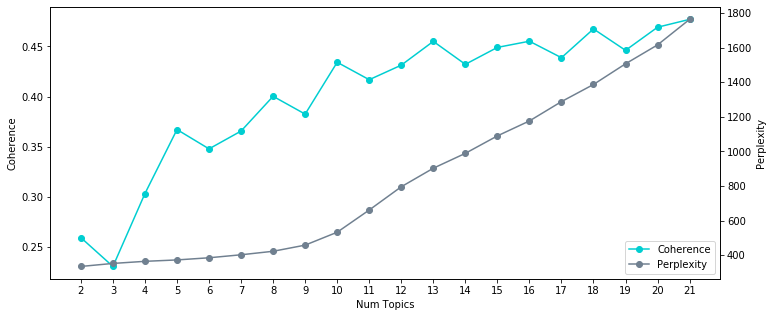

In [5]:
#Metrics for Topic Models
start = 2
limit = 22
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=1)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

# evaluation
x = range(start, limit, step)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot()

# coherence
ax1.plot(x, coherence_vals, 'o-', color='darkturquoise', label='Coherence')
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence')

# perplexity
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color='slategray', label='Perplexity')
ax2.set_ylabel('Perplexity')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

# Vis
ax1.set_xticks(x)
plt.show()

In [6]:
# トピック数の設定
NUM_TOPICS = 8

# モデル作成
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=1)

# クラスタリング結果を出力
index = [663, 4242, 4969, 6311, 6634, 6890, 7808, 7961]
for i in index:
    print(textDeta[i], end='\n')
    score_by_topic = np.zeros(NUM_TOPICS)
    for topic, score in lda_model[corpus[i]]:
        score_by_topic[int(topic)] = float(score)
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(score_by_topic[n]), end=', ')
    print('{:.2f}'.format(score_by_topic[NUM_TOPICS-1]), end="\n\n")

自分には甘いが相手のことになると相手を貶めるためだけに男尊女卑とか差別とか軽々しく使うのやめてほしい。コメンテーターレベルの議員は特に税金の無駄なんでやめてほしい。
0.01, 0.01, 0.01, 0.01, 0.92, 0.01, 0.01, 0.01

テレビでのオネェキャラへのいじりや流行り物のように男装女装を取り上げる限り日本のセクシャルマイノリティに対する理解は広まるどころか間違った方向に行くのではないかなと不安。服装、体、心、性対象を男性か女性かの二種類のどちらかに統一するものだという考えは間違えている。まずはメディアがきちんとした知識をつけて欲しい
0.00, 0.30, 0.00, 0.00, 0.00, 0.20, 0.00, 0.47

外国人選手へのインタビューを吹き替えする時に、女性選手の言葉の語尾を「〜わよ」「〜のよ」「〜わ」、男性選手の言葉の語尾を「〜なんだ」「〜だよ」などと訳すのをやめて欲しい。日本人が話しているような言葉遣いで表現してほしい。
0.33, 0.21, 0.00, 0.00, 0.42, 0.00, 0.00, 0.00

他の男に取られるくらいなら殺そうと思った
打倒だと思う 身勝手な女が多すぎる
0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.71, 0.04

美容院の店員がチャライ。男性店員は女性客には本当にチャラく見える。
0.02, 0.02, 0.02, 0.68, 0.19, 0.02, 0.02, 0.02

女性ばっかりファッションのことをやるが...男性もやって欲しい。
0.06, 0.06, 0.56, 0.06, 0.06, 0.06, 0.06, 0.06

性別の選択が男女しかなかった。LGBTからの不満は受け付けてくれないの?
0.03, 0.53, 0.29, 0.03, 0.03, 0.03, 0.03, 0.03

愛知県警察は、コンビニエンスストア「サークルK東あじま三丁目店」で勤務していた元アルバイト店員の31歳男性を強盗の疑いで逮捕し、2017年2月6日に発表しました。アルバイト店員に強盗に入られた「サークルK東あじま三丁目店」が不満で堪りません。元アルバイト店員の31歳男性は強盗に入った後も約3ケ月間、普通に働いていたと云うではないですか。なめ

### Words that belong to each topic with high probability

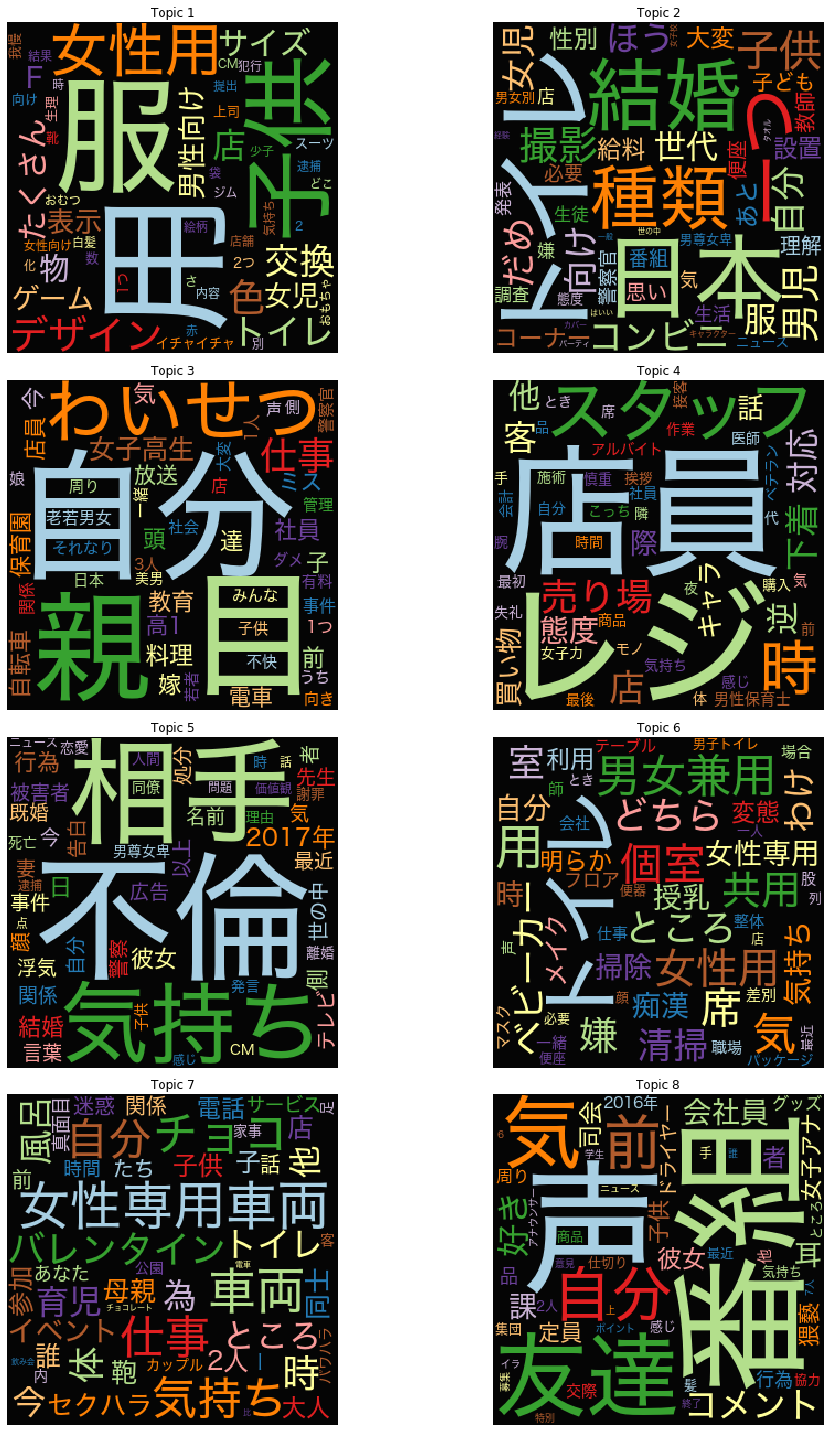

In [7]:
import math
from wordcloud import WordCloud

# WordCloud
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda_model.num_topics/2), figsize=(16,20))
axs = axs.flatten()

for i in range(lda_model.num_topics):
    x = dict(lda_model.show_topic(i, 50))
    im = WordCloud(
        background_color='black',
        font_path="/system/Library/Fonts/ヒラギノ角ゴシック W4.ttc",
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i+1))

# vis
plt.tight_layout()
plt.show()

In [8]:
import math
from wordcloud import WordCloud
from googletrans import Translator

# Translator
translator = Translator()

for i in range(lda_model.num_topics):
    print("Topic " + str(i+1) + " :")
    x = dict(lda_model.show_topic(i, 50))
    keys = [k for k, v in x.items()]
    cnt = 0
    while cnt < 10:
        trans_en = translator.translate(keys[cnt])
        print(str(cnt+1) + ":" + trans_en.text, keys[cnt])
        cnt+=1
    print()

Topic 1 :
1:use 用
2:clothes 服
3:children 子供
4:For women 女性用
5:design デザイン
6:color 色
7:Exchange 交換
8:shop 店
9:toilet トイレ
10:Stuff 物

Topic 2 :
1:toilet トイレ
2:Japan 日本
3:marry 結婚
4:type 種類
5:One 一つ
6:children 子供
7:Boy 男児
8:photograph 撮影
9:convenience store コンビニ
10:For 向け

Topic 3 :
1:myself 自分
2:Eye 目
3:Dear 親
4:Obscene わいせつ
5:jobs 仕事
6:high school girl 女子高生
7:cuisine 料理
8:head 頭
9:child 子
10:now 今

Topic 4 :
1:Clerk 店員
2:cash register レジ
3:staff スタッフ
4:Time 時
5:Sales floor 売り場
6:shop 店
7:customer 客
8:underwear 下着
9:Reverse 逆
10:Correspondence 対応

Topic 5 :
1:Cheating 不倫
2:Opponent 相手
3:Feelings 気持ち
4:2017 2017年
5:marry 結婚
6:behavior 行為
7:Girlfriend 彼女
8:day 日
9:~ side 側
10:now 今

Topic 6 :
1:toilet トイレ
2:use 用
3:unisex 男女兼用
4:Qi 気
5:Private room 個室
6:For women 女性用
7:seat 席
8:Share 共用
9:Dislike 嫌
10:room 室

Topic 7 :
1:Women-only car 女性専用車両
2:vehicle 車両
3:chocolate チョコ
4:Feelings 気持ち
5:jobs 仕事
6:myself 自分
7:Time 時
8:Valentine バレンタイン
9:body 体
10:for 為

Topic 8 :
1:sound 声
2:program 番組
3:f

In [9]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Vis PCoA
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

/opt/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.215725 -0.039553       1        1  11.145069
1      0.080273 -0.095114       2        1   9.407043
2     -0.048545  0.041602       3        1  12.051202
3     -0.059928  0.193273       4        1  14.601503
4     -0.144778 -0.162481       5        1  14.846544
5      0.077708  0.031143       6        1  13.391569
6     -0.003293  0.065631       7        1  12.907942
7     -0.117162 -0.034500       8        1  11.649127, topic_info=     Category         Freq Term        Total  loglift  logprob
89    Default  1031.000000  トイレ  1031.000000  30.0000  30.0000
161   Default   523.000000   レジ   523.000000  29.0000  29.0000
80    Default   659.000000    用   659.000000  28.0000  28.0000
164   Default   682.000000   店員   682.000000  27.0000  27.0000
256   Default   453.000000    服   453.000000  26.0000  26.0000
...       ...          ...  ...          ...      ...      ...
1512   Topic8    45.951382   行為   236.519150   0.5115  -5.6019
145    Topic8    45.200275    他   314.499847   0.2101  -5.6184
174    Topic8    46.593105   子供   469.517181  -0.1603  -5.5881
384    Topic8    42.811623   2人   215.201721   0.5352  -5.6727
838    Topic8    42.902611   最近   248.382568   0.3939  -5.6706

[565 rows x 6 columns], token_table=      Topic      Freq Term
term                      
4161      3  0.935970   0歳
6046      4  0.978393  17歳
440       1  0.345110   1つ
440       2  0.064708   1つ
440       3  0.359489   1つ
...     ...       ...  ...
48        1  0.172094    髪
48        4  0.031290    髪
48        6  0.140804    髪
48        8  0.641440    髪
7412      5  0.957667   鬼畜

[1625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])